# ML-BPMN Getting Started with scikit-learn, PMML and Camunda

*... a tutorial for students in the FHNW MSc module Digitalisation of Business Processes (DigiBP), written by [Andreas Martin, PhD](https://andreasmartin.ch).*

[![deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https%3A%2F%2Fgithub.com%2FDigiBP%2Fdigibp-camunda-classroom%2Fblob%2Fmaster%2Fmodelling%2Fpmml%2FML_Getting_Started.ipynb) [![Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DigiBP/digibp-camunda-classroom/blob/master/modelling/pmml/ML_Getting_Started.ipynb) [![Gitpod](https://img.shields.io/badge/Gitpod-Run%20in%20VS%20Code-908a85?logo=gitpod)](https://gitpod.io/#https://github.com/.../...) [![GitHub.dev](https://img.shields.io/badge/github.dev-Open%20in%20VS%20Code-908a85?logo=github)](https://github.dev/DigiBP/digibp-camunda-classroom/blob/master/modelling/pmml/ML_Getting_Started.ipynb)

This short tutorial is intended to provide a straight forward introduction to machine learning using the widely used Python library **scikit-learn** (aka sklearn).

> Trivia: The name *SciKit* is derived from its original intention being a SciPy Toolkit. SciPy is another Python library for scientific computing.

Sklearn enjoys huge popularity when it comes to classic machine learning methods; it is well documented, has a large developer community and besides the official documentation there are plenty of other good resources for the ML toolkit available on the web.

> Sklearn is intended for **classical ML** and **not for Deep Learning**, although a Multi-layer Perceptron (MLP), for example, can be trained. Since Sklearn does **not support GPUs**, it is not suitable for large-scale applications.

## Data and Use Case
This tutorial uses historical data from an expense reporting and audit process — the **order approval process** is depicted in the following Fig a:

![](https://github.com/AI4BP/ainotes/raw/main/ipynb/order-approval-process/images/order-approval-sklearn.png)

**Fig a**: approval process

This (possibly synthetic) data was collected by humans, which is approved or not based on the expense **category**, **urgency**, **target price** and actual **price** paid.

> This use case has been inspired by an example/article of Donato Marrazzo (Red Hat, Inc.). He provided data, in a related GitHub repository [[1]](https://github.com/dmarrazzo/rhdm-dmn-pmml-order), of an **expense approval process**, which is used here in this tutorial, along with a series of articles ([[2]](https://developers.redhat.com/blog/2021/01/14/knowledge-meets-machine-learning-for-smarter-decisions-part-1#conclusion) and [[3]](https://developers.redhat.com/blog/2021/01/22/knowledge-meets-machine-learning-for-smarter-decisions-part-2#conclusion)).

### 🚧 Main Task
The task in this tutorial is to train an ML model step by step and then generate a PMML file, which then implements the `Approve expense order (PMML)` activity depicted in Fig a.

## 0. Initialization
In the following there is some code for initialization. For example, the URL to the data `url_data` and the BPMN/DMN models `url_modelling` is set.

Further on, if necessary, the `sklearn2pmml` must be organised in advance via pip. Since `sklearn2pmml` requires the JRE (Java Runtime Environment), JRE may have to be installed beforehand, depending on the Jupyter environment.

In [1]:
url_github = "https://raw.githubusercontent.com/AI4BP/ainotes/main"
project_name = "order-approval-process"
url_data = f"{url_github}/data/{project_name}"
url_modelling = f"{url_github}/modelling/{project_name}"

try:
    import sklearn2pmml
except:
    !pip -qq install sklearn2pmml

from sklearn2pmml import _java_version

if _java_version("UTF-8") is None:
    !sudo apt -qq update > /dev/null
    !sudo apt -qq install -y default-jre > /dev/null

print(_java_version("UTF-8"))

('openjdk', '11.0.12')


## 1. Load the CSV File
Load the CSV file from GitHub and feed the data into the *data* variable by using [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). Pandas is intended to be a data analysis and manipulation tool, which is used here and the following steps until dataset separation.

In [2]:
import pandas

data = pandas.read_csv(f"{url_data}/order-approval.csv", sep = ",")

data

,category,urgency,targetPrice,price,approved
0,basic,medium,790,837,True
1,basic,high,1250,1734,False
2,optional,low,670,944,False
3,basic,medium,1550,1728,True
4,optional,medium,630,988,False
...,...,...,...,...,...
3995,basic,high,580,903,False
3996,basic,high,2950,3063,True
3997,basic,low,1600,1601,True
3998,basic,high,1890,1994,True


## 2. Map Categories to Numbers
If we investigate the output of the loaded data in the previous step, we see, that **category** and **urgency** are some categorical strings. To feed that data into our ML model, we need to convert and map the categorical strings to numbers. So we map...: 
- category *optional* to 0
- category *basic* to 1
- urgency *low* to 0
- urgency *medium* to 1
- urgency *high* to 2

In [3]:
category = {'optional': 0,'basic': 1}
data.category = [category[item] for item in data.category]
urgency = {'low': 0,'medium': 1,'high': 2}
data.urgency = [urgency[item] for item in data.urgency]

data

,category,urgency,targetPrice,price,approved
0,1,1,790,837,True
1,1,2,1250,1734,False
2,0,0,670,944,False
3,1,1,1550,1728,True
4,0,1,630,988,False
...,...,...,...,...,...
3995,1,2,580,903,False
3996,1,2,2950,3063,True
3997,1,0,1600,1601,True
3998,1,2,1890,1994,True


## 3. Data Segregation and Feature Selection
If we investigate the output of the mapped data in the previous step, we see, that we have **category**, **urgency**, **target price** and actual **price** features with "input" data, or in ML terminology **samples/design matrix** usually denoted as **X**.

The **approved** column is the "output or decision" data, or in ML terminology the **target values** denoted as **y**.

For further processing, we need to segregate **X** and **y** as follows.

In [4]:
X_data = data.drop('approved',axis=1)
y_data = data.approved

print("X Data:\n", X_data)
print("y Data:\n", y_data)

X Data:
       category  urgency  targetPrice  price
0            1        1          790    837
1            1        2         1250   1734
2            0        0          670    944
3            1        1         1550   1728
4            0        1          630    988
...        ...      ...          ...    ...
3995         1        2          580    903
3996         1        2         2950   3063
3997         1        0         1600   1601
3998         1        2         1890   1994
3999         1        0         2540   2921

[4000 rows x 4 columns]
y Data:
 0        True
1       False
2       False
3        True
4       False
        ...  
3995    False
3996     True
3997     True
3998     True
3999    False
Name: approved, Length: 4000, dtype: bool


## 4. Data Partitioning
Training or, in ML terminology, fitting a model to data, does not mean that it will produce acceptable predictions on new data. Therefore, we split / partition the data set into a training and a testing set to be able to evaluate the performance. To accomplish this, the function [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) of scikit-learn can be used.
- In the following, we slit the X and y data sets by 60% training and 40% testing sets defined by the `test_size=0.40` parameter.
- The `random_state=` parameter can be adjusted from `none` to an *int* value for a reproducible output across multiple executions.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.40, random_state=None)

print("X_train:\n", X_train)
print("y_train:\n", y_train)
print("X_test:\n", X_test)
print("y_test:\n", y_test)

X_train:
       category  urgency  targetPrice  price
1568         0        0         1620   2064
2119         0        2         1460   1908
2401         1        1         1830   2131
3803         0        1         1060   1210
3518         0        2         2490   2540
...        ...      ...          ...    ...
2164         1        0         1340   1548
625          1        0         3210   3373
2990         1        0          390    863
611          1        1           40     97
3681         0        0         3230   3398

[2400 rows x 4 columns]
y_train:
 1568    False
2119    False
2401     True
3803    False
3518     True
        ...  
2164    False
625      True
2990    False
611     False
3681     True
Name: approved, Length: 2400, dtype: bool
X_test:
       category  urgency  targetPrice  price
2009         1        1         3220   3397
1262         1        0         2990   3406
366          0        1         3170   3376
457          1        2         2760   3199
35

### 🚧 Supplementary Tasks
1. Try to adjust the split parameter `test_size=`, e.g., 80/20, 70/30, 75/25 or even 50/50.
2. Investigate what happens when the `random_state=` parameter is, e.g., `0`.

## 5. Initialize Learner
Now we are going to initialize the learner for our classification problem. Sklearn provides a vide range of models for supervised and unsupervised learning. Andre Ye (2021) has provided on [Medium, towards data science,](https://towardsdatascience.com/your-ultimate-data-mining-machine-learning-cheat-sheet-9fce3fa16) a nice cheat-sheet for sklearn which can be recommended for further reading. From him, the following Fig 5a has been taken, showcasing a subset of the most important classifiers in sklearn.

![](https://github.com/AI4BP/ainotes/raw/main/ipynb/order-approval-process/images/sklearn%20classifier%20models%20Ye%2C%202021.png)

**Fig 5a**: sklearn classifier models ([Ye, 2021](https://towardsdatascience.com/your-ultimate-data-mining-machine-learning-cheat-sheet-9fce3fa16))

### Logistic Regression

Our default model in this tutorial will be a linear model called `LogisticRegression`. Even if the name suggests otherwise, this is a linear model for classification rather than regression.

> Classification vs. regression: **classification** is about predicting an assignment to a **class**, whereas **regression** is about predicting a certain **score**. 

So we are going to initialize a logistic regression (logit) model from scikit-learn by importing and using [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with the following parameters:
- `max_iter=1000` defines the maximum number of iterations taken for the solvers to converge.
- `multi_class='auto'` is automatically selecting an appropriate approach; in binary situations, it uses the one-vs-rest (OvR) approach.


In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, multi_class='auto')

print("Model: ", model)

Model:  LogisticRegression(max_iter=1000)


### 🚧 Supplementary Tasks
Try to experiment with other classification models from sklearn as well (you have to uncomment it):

In [7]:
# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier()

In [8]:
# from sklearn.svm import SVC
# model = SVC()

In [9]:
# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()

In [10]:
# from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier()

> ‼️ You can only initialize one model per run of the pipeline.

## 6. Tune Class Weights
The author, Donato Marrazzo (Red Hat, Inc.), of the article ([[2]](https://developers.redhat.com/blog/2021/01/14/knowledge-meets-machine-learning-for-smarter-decisions-part-1#conclusion)) from which this dataset is from had an interesting idea. It maybe would be better to reject a correct expense claim than to accept an incorrect one, as rejected expense claims can be re-verified by humans. Therefore, one could try to reduce the weight of accepted expense claims.

Therefore, it might be worth considering setting the weight of rejected (`False`) claims to 1 (`False : 1`) and that of accepted (`True`) cases to about 0.6 (`True : 0.6`).


In [11]:
model.class_weight ={
    False : 1,
    True : 0.6
}

print("Model: ", model)

Model:  LogisticRegression(class_weight={False: 1, True: 0.6}, max_iter=1000)


### 🚧 Supplementary Tasks

Try experimenting with other weight values as well.

## 7. Train Model
Now we can train the configured model on the training set by using the sklearn `fit` method.

In [12]:
model.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1, True: 0.6}, max_iter=1000)

## 8. Make Predictions

After training, we can use our testing set to make predictions by using the `predict` method sklearn. With the prediction, we can now retrieve and calculate performance metrics.

In [13]:
y_pred = model.predict(X_test)

print("Predictions (y): ", y_pred)

Predictions (y):  [ True  True  True ...  True False False]


## 9. Scoring
Using various scoring metrics, we can examine how well the trained model performs on the test set.

### 9.1 Precision, Recall, F1 and Accuracy
In the following, multiple methods of sklearn are used to get overall precision, recall, F1 and overall accuracy.


> In a binary classification, the precision indicates the ratio of correctly predicted positive results (TP) in relation to the total of all results predicted as positive (TP + FP). The recall indicates the ratio of results correctly classified as positive (TP) in relation to the total of actually positive results (TP + FN).


> In general, the F1 score is the mean of precision and recall. The accuracy score assesses the accuracy of the correct predictions.

In [14]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

RS = recall_score(y_test, y_pred)
print(f"Recall Score (RS): {100 * RS:.2f}%")

PS = precision_score(y_test, y_pred)
print(f"Precision Score (PS): {100 * PS:.2f}%")

F1 = f1_score(y_test, y_pred)
print(f"F1: {100 * F1:.2f}%")

AS = accuracy_score(y_test, y_pred)
print(f"Accuracy Score (AS): {100 * AS:.2f}%")

Recall Score (RS): 92.34%
Precision Score (PS): 97.07%
F1: 94.65%
Accuracy Score (AS): 94.38%


In the following, a classification report can be generated by using the `classification_report` method of sklearn to get precision, recall and F1 on each class or label.

In [15]:
from sklearn.metrics import classification_report

CR = classification_report(y_test, y_pred)

print("Classification Report (CR):\n", CR)

Classification Report (CR):
               precision    recall  f1-score   support

       False       0.92      0.97      0.94       738
        True       0.97      0.92      0.95       862

    accuracy                           0.94      1600
   macro avg       0.94      0.95      0.94      1600
weighted avg       0.95      0.94      0.94      1600



### 9.2 Confusion Matrix
In the following, a confusion matrix can be generated by using the `confusion_matrix` method of sklearn.

> In binary classification problems, the confusion matrix consists of the number of true positive (TP), true negative (TN), false positive (FP) and false negative (FN) predictions.

In [16]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, y_pred)

print("Confusion Matrix (CM):\n", CM)

Confusion Matrix (CM):
 [[714  24]
 [ 66 796]]


The generated confusion matrix can be plotted with `ConfusionMatrixDisplay` of sklearn.

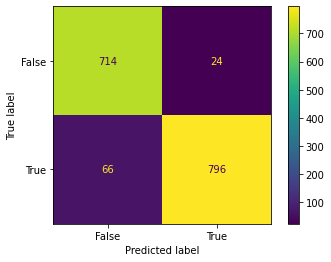

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=model.classes_)
disp.plot(values_format='')

#### Interpreting the Confusion Matrix
In a binary classification problem (as it is the case in this application scenario), one can interpret the plot as follows:
- Top-right: Number of cases where they actually not have a true label and the true label was predicted. So it is (**FP**) **F**alse that it is true (**P**ositive). In our case, we must minimize this!
- Bottom-left: Number of cases where they actually have a true label and the true label was not predicted. So it is (**FN**) **F**alse that it is false (**N**egative). In our case, we maybe can minimize this.
- Top-left: Number of cases where they actually not have a true label and the true label was not predicted. So it is (**TN**) **T**rue that it is false (**N**egative).
- Bottom-right: Number of cases where they actually have the true label and the true label was predicted. So it is (**TP**) **T**rue that it is true (**P**ositive).

## 10. PMML Export
Finally, the trained model can now be exported with the library [sklearn2pmml](https://github.com/jpmml/sklearn2pmml) to PMML.



In [18]:
import sklearn2pmml

pmml_file_name = "order-approval-sklearn.pmml"

from sklearn2pmml import make_pmml_pipeline, sklearn2pmml

pipeline = make_pmml_pipeline(
    model,
    active_fields= ["category", "urgency", "targetPrice", "price"],
    target_fields= ["approved"]
)
sklearn2pmml(pipeline, pmml_file_name)

## 11. PMML Deployment
After we have created the PMML file, we can upload it with the follwing code:

In [19]:
import requests

camunda_eninge_rest = "https://digibp.herokuapp.com/engine-rest/deployment/create"

request_file = {
    pmml_file_name: (pmml_file_name, open(pmml_file_name, "rb"))
}

request_data = {
    "tenant-id": "showcase",
}

response = requests.post(camunda_eninge_rest, files=request_file, data=request_data)
deployment_id = response.json()["id"]

print(deployment_id)

19ec469d-4ba3-11ec-88c6-36adeb5cb3b8


### 🔀 Alternative Way
As an alternative approach, we can upload the PMML file to the Camunda Platform with the Camunda Modeler as shown in Fig 11.

![](https://github.com/AI4BP/ainotes/raw/main/ipynb/order-approval-process/images/order-approval-camunda-pmml-deploy.png)

**Fig 11**: deployment of a PMML file with the Camunda Modeler

For the next step 11, we may need to investigate the `deployment-id` of the deployments within the Camunda Platform Cockpit.

## 12. PMML Testing
For executing the PMML files together with a Camunda Workflow, we can use the provided classroom instantiation, which has been extended with `jpmml`, the [Java PMML API](https://github.com/jpmml). Now can use the obtained `deployment-id` to construct the `requests` url - **so please change the following** `deployment_id`.

In [20]:
try: deployment_id
except: deployment_id = "f85423d8-47e1-11ec-834e-eea2248ab9a4" # please change the deployment-id!

evaluate_url = f"https://digibp.herokuapp.com/pmml/{deployment_id}/{pmml_file_name}/evaluate"

print(evaluate_url)

https://digibp.herokuapp.com/pmml/19ec469d-4ba3-11ec-88c6-36adeb5cb3b8/order-approval-sklearn.pmml/evaluate


Now we are ready to send a `GET` request to the DigiBP PMML API to retrieve our input variable structure of our deployed PMML file.

In [21]:
import requests, json

response = requests.get(f"{evaluate_url}/generate-input")

print(json.dumps(response.json(), indent=2))

{
  "variables": {
    "targetPrice": null,
    "urgency": null,
    "price": null,
    "category": null
  }
}


Finally, in this step, we can copy-and-paste the input variable structure from above as input to the `payload` variable and adjust the values.

In [22]:
payload = {
  "variables": {
    "targetPrice": 520,
    "urgency": 0,
    "price": 480,
    "category": 1
  }
}

response = requests.post(evaluate_url, json=payload)

print(json.dumps(response.json(), indent=2))

{
  "variables": {
    "approved": true,
    "probability(false)": 0.017270109117561216,
    "probability(true)": 0.9827298908824388
  }
}


We now should have received a possible output (prediction) of the PMML evaluation. In this use case, we should receive an `approved` variable, which is of type `Boolean`.

### 🔀 Alternative Way
This step is an alternative approach by using a Swagger UI. The provided classroom instantiation provides an own basic testing Swagger UI. This [PMML API Swagger UI](https://digibp.herokuapp.com/swagger-ui/#/pmmlapi) gives us the possibility, to `generate-input` fields and `evaluate` our PMML model as depicted in Fig 12.

![](https://github.com/AI4BP/ainotes/raw/main/ipynb/order-approval-process/images/camunda-pmml-api.png)

**Fig 12**: PMML API Swagger UI

## 13. Decision Task and PMML Connector
With the configuration insights from the PMML API, one can now configure the decision task within the BPMN model by using the Camunda Modeler. The classroom instantiation has been extended with a specific Camunda Connector for PMML, which can be used to execute a PMML model, provide input data from workflow variables and pass on output data (predictions) to workflow variables. Fig 13 shows the configurations required on the `order-approval-sklearn-init.bpmn` ([download BPMN model - here](https://ghcdn.rawgit.org/AI4BP/ainotes/main/ipynb/order-approval-process/modelling/order-approval-sklearn-init.bpmn)) process.

![](https://github.com/AI4BP/ainotes/raw/main/ipynb/order-approval-process/images/order-approval-camunda-pmml.png)

**Fig 13**: PMML-connector configuration in Camunda Modeler

## 14. DMN Variable Mapping and Deployment
In step 2 we mapped the text values to numerical values. We now have to map these in the process as shown in Fig 14a, as we are working with strings in the workflow.

![](https://github.com/AI4BP/ainotes/raw/main/ipynb/order-approval-process/images/automatic-approval-mapping-urgency.png)

**Fig 14a**: variable mapping in DMN

Then download the `automatic-approval-mapping.dmn` ([download DMN model - here](https://ghcdn.rawgit.org/AI4BP/ainotes/main/ipynb/order-approval-process/modelling/automatic-approval-mapping.dmn)).

Finally, you can upload the entire package as shown in Fig 14b, consisting of the BPMN, the DMN and the PMML file to the server and start the process.

![](https://raw.githubusercontent.com/AI4BP/ainotes/main/ipynb/order-approval-process/images/order-approval-camunda-pmml-deploy.png)

**Fig 14b**: deployment of the a BPMN, DMN and PMML file with the Camunda Modeler

### 🔀 Alternative Way
Instead of using the Camunda Modeler to configure the rule task in the BPMN model, we can deploy the entire package including the pre-configured BPMN file by executing the following code.

In [27]:
import requests

bpmn_file_name = "order-approval-sklearn.bpmn"
bpmn_file = requests.get(f"{url_modelling}/{bpmn_file_name}")
dmn_file_name = "automatic-approval-mapping.dmn"
dmn_file = requests.get(f"{url_modelling}/{dmn_file_name}")

files = {pmml_file_name:open(pmml_file_name, "rb"), bpmn_file_name:bpmn_file.content, dmn_file_name:dmn_file.content}

request_data = {
     "tenant-id" : "showcase",
}

response = requests.post(camunda_eninge_rest, files=files, data=request_data)
deployment_id = response.json()["id"]

print(deployment_id)

https://raw.githubusercontent.com/AI4BP/ainotes/main/modelling/order-approval-process
<Response [404]>
<Response [500]>


KeyError: 'id'

## 15. Conclusion
🎉 Now, finally, we can instantiate and run the process from the Camunda Platform task list.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3cfa0341-d9ff-404f-9c44-bcc446a7617d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>